In [1]:
cd /home/ubuntu/FedEM/

/home/ubuntu/FedEM


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from torch.utils.tensorboard import SummaryWriter
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *

from transfer_attacks.TA_utils import *
from transfer_attacks.Boundary_Transferer import *

In [3]:
# Manually set argument parameters
args_ = Args()
args_.experiment = "cifar100"
args_.method = "FedEM_adv"
args_.decentralized = False
args_.sampling_rate = 1.0
args_.input_dimension = None
args_.output_dimension = None
args_.n_learners= 3
args_.n_rounds = 10
args_.bz = 128
args_.local_steps = 1
args_.lr_lambda = 0
args_.lr =0.03
args_.lr_scheduler = 'multi_step'
args_.log_freq = 10
args_.device = 'cuda'
args_.optimizer = 'sgd'
args_.mu = 0
args_.communication_probability = 0.1
args_.q = 1
args_.locally_tune_clients = False
args_.seed = 1234
args_.verbose = 1
args_.save_path = 'weights/cifar/22_01_09_fedavg_n80_benign/'
args_.validation = False
args_.num_user = 50

# Generate the dummy values here
aggregator, clients = dummy_aggregator(args_, num_user=50)

==> Clients initialization..
===> Building data iterators..


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 349.73it/s]


===> Initializing clients..


100%|█████████████████████████████████████████| 100/100 [00:53<00:00,  1.85it/s]


==> Test Clients initialization..
===> Building data iterators..


0it [00:00, ?it/s]


===> Initializing clients..


0it [00:00, ?it/s]


++++++++++++++++++++++++++++++
Global..
Train Loss: 4.608 | Train Acc: 1.017% |Test Loss: 4.608 | Test Acc: 1.067% |
++++++++++++++++++++++++++++++++++++++++++++++++++
################################################################################


In [4]:
# Combine Validation Data across all clients as test
data_x = []
data_y = []

for i in range(len(clients)):
    daniloader = clients[i].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)
        data_y.append(y)

data_x = torch.stack(data_x)
data_y = torch.stack(data_y)

# Create dataloader from validation dataset that allows for diverse batch size
dataloader = Custom_Dataloader(data_x, data_y)

In [10]:
exp_names = ['weights/neurips/cifar100/prop/none_G05/prop_n1/',
             'weights/neurips/cifar100/prop/none_G05/prop_n2/',
             'weights/neurips/cifar100/prop/none_G05/prop_n5/',
             'weights/neurips/cifar100/prop/none_G05/prop_n10/',
             'weights/neurips/cifar100/prop/none_G05/prop_n20/',
             'weights/neurips/cifar100/prop/none_G05/prop_n40/']

# exp_names = ['weights/neurips/cifar100/prop/with_G05/prop_n1/',
#              'weights/neurips/cifar100/prop/with_G05/prop_n2/',
#              'weights/neurips/cifar100/prop/with_G05/prop_n5/',
#              'weights/neurips/cifar100/prop/with_G05/prop_n10/',
#              'weights/neurips/cifar100/prop/with_G05/prop_n20/',
#              'weights/neurips/cifar100/prop/with_G05/prop_n40/']

train_item = 'train_client_weights.npy'

In [11]:
num_victims = 50
num_exp = len(exp_names)
# Set Up Dictionaries -- list holds the adversary idx
exp_logs = {}

for j in range(num_exp):
    logs_adv = []

    for i in range(num_victims):
        adv_dict = {}
        adv_dict['orig_acc_transfers'] = None
        adv_dict['orig_similarities'] = None
        adv_dict['adv_acc_transfers'] = None
        adv_dict['adv_similarities_target'] = None
        adv_dict['adv_similarities_untarget'] = None
        adv_dict['adv_target'] = None
        adv_dict['adv_miss'] = None
        adv_dict['metric_alignment'] = None
        adv_dict['ib_distance_legit'] = None
        adv_dict['ib_distance_adv'] = None
        
        logs_adv += [adv_dict]
    
    exp_logs[j] = copy.deepcopy(logs_adv)


In [12]:
# Inter Boundary Distance Metric
custom_batch_size = 500


for j in range(num_exp):
    print('processing file', exp_names[j], '...')
    
    # Change name if need be
    args_.save_path = exp_names[j]

    # Import weights for aggregator
    aggregator.load_state(args_.save_path)

    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
        
    weight_name = args_.save_path + train_item
    weights = np.load(weight_name)
    np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

    # Set model weights
    model_weights = []
    num_models = num_victims

    for i in range(num_models):
        model_weights += [weights[i]]


    # Generate the weights to test on as linear combinations of the model_weights
    models_test = []

    for (w0,w1,w2) in model_weights:
        # first make the model with empty weights
        new_model = copy.deepcopy(hypotheses[0].model)
        new_model.eval()
        new_weight_dict = copy.deepcopy(weights_h[0])
        for key in weights_h[0]:
            new_weight_dict[key] = w0*weights_h[0][key]  + w1*weights_h[1][key] +w2*weights_h[2][key] 
        new_model.load_state_dict(new_weight_dict)
        models_test += [new_model]
    

    victim_idxs = range(num_victims)

    for adv_idx in victim_idxs:
        print("\t Adv idx:", adv_idx)
        # Perform Attacks
        dataloader = load_client_data(clients = clients, c_id = adv_idx, mode = 'test') # or test/train
        batch_size = min(custom_batch_size, dataloader.y_data.shape[0])
        
        t1 = Transferer(models_list=models_test, dataloader=dataloader)
        t1.generate_victims(victim_idxs)
        
        t1.atk_params = PGD_Params()
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = 3, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)

        t1.generate_advNN(adv_idx)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        # t1.check_empirical_metrics(orig_flag = True)

        # Log Performance
        exp_logs[j][adv_idx]['orig_acc_transfers'] = copy.deepcopy(t1.orig_acc_transfers)
        exp_logs[j][adv_idx]['orig_similarities'] = copy.deepcopy(t1.orig_similarities)
        exp_logs[j][adv_idx]['adv_acc_transfers'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_target'] = copy.deepcopy(t1.adv_similarities)        
        exp_logs[j][adv_idx]['adv_target'] = copy.deepcopy(t1.adv_target_hit)

        # Miss attack
        t1.atk_params.set_params(batch_size=batch_size, iteration = 10,
                       target = -1, x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                       step_size = 0.05, step_norm = "inf", eps = 4, eps_norm = 2)
        t1.generate_xadv(atk_type = "pgd")
        t1.send_to_victims(victim_idxs)
        exp_logs[j][adv_idx]['adv_miss'] = copy.deepcopy(t1.adv_acc_transfers)
        exp_logs[j][adv_idx]['adv_similarities_untarget'] = copy.deepcopy(t1.adv_similarities)


    del models_test

processing file weights/neurips/cifar100/prop/none_G05/prop_n1/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 Adv idx: 13
	 Adv idx: 14
	 Adv idx: 15
	 Adv idx: 16
	 Adv idx: 17
	 Adv idx: 18
	 Adv idx: 19
	 Adv idx: 20
	 Adv idx: 21
	 Adv idx: 22
	 Adv idx: 23
	 Adv idx: 24
	 Adv idx: 25
	 Adv idx: 26
	 Adv idx: 27
	 Adv idx: 28
	 Adv idx: 29
	 Adv idx: 30
	 Adv idx: 31
	 Adv idx: 32
	 Adv idx: 33
	 Adv idx: 34
	 Adv idx: 35
	 Adv idx: 36
	 Adv idx: 37
	 Adv idx: 38
	 Adv idx: 39
	 Adv idx: 40
	 Adv idx: 41
	 Adv idx: 42
	 Adv idx: 43
	 Adv idx: 44
	 Adv idx: 45
	 Adv idx: 46
	 Adv idx: 47
	 Adv idx: 48
	 Adv idx: 49
processing file weights/neurips/cifar100/prop/none_G05/prop_n2/ ...
	 Adv idx: 0
	 Adv idx: 1
	 Adv idx: 2
	 Adv idx: 3
	 Adv idx: 4
	 Adv idx: 5
	 Adv idx: 6
	 Adv idx: 7
	 Adv idx: 8
	 Adv idx: 9
	 Adv idx: 10
	 Adv idx: 11
	 Adv idx: 12
	 

Organizing and plotting data

In [13]:
metrics = ['orig_acc_transfers','orig_similarities','adv_acc_transfers','adv_similarities_target',
           'adv_similarities_untarget','adv_target','adv_miss'] #,'metric_alignment']


orig_acc = []
orig_sim = []
adv_acc = []
adv_sim_target = []
adv_sim_untarget = []
adv_target = []
adv_miss = []

for i in range(len(exp_names)):
    orig_acc += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    orig_sim += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_acc += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_target += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_sim_untarget += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    adv_target += [np.zeros([len(victim_idxs),len(victim_idxs)])]
    adv_miss += [np.zeros([len(victim_idxs),len(victim_idxs)]) ]
    
    for adv_idx in range(len(victim_idxs)):
        for victim in range(len(victim_idxs)):
            orig_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[0]][victim_idxs[victim]].data.tolist()
            orig_sim[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[1]][victim_idxs[victim]].data.tolist()
            adv_acc[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[2]][victim_idxs[victim]].data.tolist()
            adv_sim_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[3]][victim_idxs[victim]].data.tolist()
            adv_sim_untarget[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[4]][victim_idxs[victim]].data.tolist()
            adv_target[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[5]][victim_idxs[victim]].data.tolist()
            adv_miss[i][adv_idx,victim] = exp_logs[i][victim_idxs[adv_idx]][metrics[6]][victim_idxs[victim]].data.tolist()

In [14]:
# Edit desired data\

# Acc
y_acc = []
y_robust = []
y_target = []
for i in range(len(exp_names)):
    y_acc += [np.mean(np.diagonal(orig_acc[i]))]
    y_robust += [avg_nondiag(adv_miss[i])]
    y_target += [avg_nondiag(adv_target[i])]
    
print('y_acc', y_acc)
print('y_robust', y_robust)
print('y_target', y_target)

y = [y_acc, y_robust, y_target]

y_acc [0.40850002229213717, 0.4130000227689743, 0.4031666886806488, 0.40866668879985807, 0.4050000214576721, 0.3845000201463699]
y_robust [0.039870750415233934, 0.04428911818457501, 0.05954762234409549, 0.08246939230824307, 0.1223469455429942, 0.14258164042987082]
y_target [0.17628447387823645, 0.1666753683364665, 0.10282394312132073, 0.11508399316888987, 0.07934175063076676, 0.049685226355736356]


Text(0.5, 1.0, 'CIFAR-100 Robustness Propagation')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


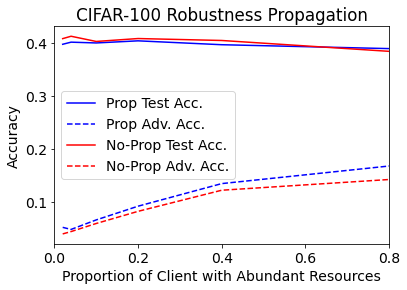

In [4]:
# G = 0.15 version
# y_acc_prop = [0.39916668713092807, 0.40600002110004424, 0.4071666866540909, 0.39850001990795136, 0.41266668975353243, 0.4131666910648346]
# y_robust_prop = [0.042010206433811356, 0.051221091183168546, 0.06462245261790801, 0.0951836786153061, 0.08510884813546223, 0.10267007377264756]
# y_target_prop = [0.1491476929887217, 0.14469148566300163, 0.10993787136613106, 0.09009570505888183, 0.08397643180944178, 0.06470972027629614]

# y_acc_no = [0.3958333545923233, 0.3991666877269745, 0.40700002014636993, 0.4001666867733002, 0.40566668897867203, 0.4081666874885559]
# y_robust_no = [0.03804421974916239, 0.05258163562576686, 0.04871088702573764, 0.05039456057761397, 0.061068030493524, 0.10164966529995507]
# y_target_no = [0.17821779224869547, 0.13016996177445564, 0.14617329893063527, 0.1251134109721348, 0.17111005410057853, 0.1113952955873493]

# G = 0.5 Version
y_acc_prop = [0.3978333562612534, 0.40183335423469546, 0.4003333556652069, 0.40433335304260254, 0.39700002312660215, 0.3896666878461838]
y_robust_prop = [0.05225510478817991, 0.04834353998645532, 0.06627891512207534, 0.09218367841626916, 0.13484014325224014, 0.16804762795491487]
y_target_prop = [0.13602813613125864, 0.15776523901225656, 0.1175313228847725, 0.10207385485079519, 0.06633625009420271, 0.03559203076841576]


y_acc_no = [0.40850002229213717, 0.4130000227689743, 0.4031666886806488, 0.40866668879985807, 0.4050000214576721, 0.3845000201463699]
y_robust_no = [0.039870750415233934, 0.04428911818457501, 0.05954762234409549, 0.08246939230824307, 0.1223469455429942, 0.14258164042987082]
y_target_no = [0.17628447387823645, 0.1666753683364665, 0.10282394312132073, 0.11508399316888987, 0.07934175063076676, 0.049685226355736356]

y1 = [y_acc_prop, y_robust_prop]
y2= [y_acc_no, y_robust_no]

tot = 50
x = [1/tot,2/tot,5/tot,10/tot,20/tot,40/tot]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

names1 = ['Prop Test Acc.', 'Prop Adv. Acc.']
names2 = ['No-Prop Test Acc.', 'No-Prop Adv. Acc.']
colors = ['b','r']
types = ['-', '--']

for i in range(len(names1)):
    plt.plot(x,y1[i],label= names1[i], linestyle = types[i], color = colors[0])
for i in range(len(names2)):
    plt.plot(x,y2[i],label= names2[i], linestyle = types[i], color = colors[1])
plt.legend(frameon=True)
plt.xlim(0, 0.8);
# plt.ylim(0, 1.0);
plt.xlabel('Proportion of Client with Abundant Resources')
plt.ylabel('Accuracy')
plt.title("CIFAR-100 Robustness Propagation")

